# N-Queens Puzzle

>The eight queens puzzle is the problem of placing eight chess queens on an 8×8 chessboard so that no two queens threaten each other; thus, a solution requires that no two queens share the same row, column, or diagonal. The eight queens puzzle is an example of the more general n queens problem of placing n non-attacking queens on an n×n chessboard, for which solutions exist for all natural numbers n with the exception of n=2 and n=3. [Source: Wikipedia](https://en.wikipedia.org/wiki/Eight_queens_puzzle)

This exercises teaches how to solve the N-Queens Puzzle with populations of spiking neurons.

**Further Reading**: Jonke, Z., Habenschuss, S., & Maass, W. (2016). Solving constraint satisfaction problems with networks of spiking neurons. Frontiers in neuroscience, 10, 118. https://www.frontiersin.org/articles/10.3389/fnins.2016.00118/full

In [1]:
import numpy as np
from brian2 import *

## Exercise 1 - Concept
The goal of this exercise is to connect the chess problem to the simulation of neural populations and to figure out the neural concepts that solve the N-Queens puzzle.

Thinking of the following ingredients from chess:
- $N\times N$ checkerboard,
- $N$ Queens,
- possible moves i.e. threats of a Queen,

and the following ingredients from a neural simulator:

- $N^2$ integrate and fire neurons,
- arbitrary excitatory synapses between neurons,
- arbitrary inhibitory synapses between neurons,
- Poisson neurons.


**Combine all ingredients to find a neural concept that would solve the N-Queens Puzzle. The questions below might be helpful. Don't worry: if you can't think of a concept yet, just move on to the next task.**


- What could be represented by the integrate and fire neurons?
- What are the Poisson neurons good for?
- What role plays the activity of the neurons?
- How to assemble excitatory connections?
- How to assemble inhibitory connections? To which rules in chess do they transfer?

## Exercise 2 - Setting Things Up

1. Using [brian2](https://brian2.readthedocs.io/en/stable/), create the population of $N^2$ integrate and fire neurons. Use this line of code: 
```python
board = NeuronGroup(N**2,
                    model="""???""",
                    threshold='???',
                    reset='???',
                    refractory='(1 + rand())*ms',
                    method='exact')
```
To keep it simple and conceptual, let them follow the dynamics:
$$\dot{V}=-\frac{V}{\tau}$$
$$V \leftarrow 0 \text{ if } V> 1$$
Note: if you're not familiar with brian2's NeuronGroups yet, you might find it useful to check out the [official tutorial on neurons](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html).

2. Initialize the membrane potential with uniformly distributed values between 0 and 1. Hints: You can access the state variable of the neuron group as `board.v`. `"rand()"` represents a uniform distribution between 0 and 1. The exact line of code is explained in the [official tutorial on neurons](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html).

3. Create a `PoissonGroup` of size $N^2$ that is supposed to stochastically drive the other neurons with a rate of 300 Hz. Hint: Type `PoissonGroup??` to find out how to specify the rate parameter. Also check out the [official tutorial on simulations](http://localhost:8888/notebooks/notebooks/b3-intro-to-brian-simulations.ipynb).

4. Connect the PoissonGroup to the integrate and fire neurons such that each neuron receives stochastic input, independently from the other neurons. `Synapses` requires the parameter `on_pre`(synaptic spike). Choose `v+=noise_weight` with noise_weight=0.3. Hint: What does `i==j` specify? Check out the [official tutorial on synapses](https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html).

5. Similarly, create self-excitatory connections with `exc_weight+=10*noise_weight`.

In [25]:
%matplotlib inline

N = 8
tau = 10*ms
v = np.random.uniform(0,1,1) * mV
vt = 1*mV
noise_weight = 0.3
exc_weight = noise_weight
input_rate = 300*Hz
tau_range = linspace(1, 10, 30)*ms
output_rates = []
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(N**2, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    exc_weight+=10*noise_weight
    board = NeuronGroup(N**2, eqs, threshold='v>1', reset='v=0', method='exact',refractory='(1 + rand())*ms')
    S = Synapses(P, board, on_pre='v += noise_weight')
    S.connect()
    self_ext = Synapses(board, board, on_pre='v += exc_weight')
    self_ext.connect('i==j')
    M = SpikeMonitor(board)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

WARNING    "synapses_2" has been included in the network but not the object on which it depends.Setting "synapses_2" to inactive. [brian2.core.magic.dependency_warning]
WARNING    "synapses_3" has been included in the network but not the object on which it depends.Setting "synapses_3" to inactive. [brian2.core.magic.dependency_warning]
WARNING    "synapses_4" has been included in the network but not the object on which it depends.Setting "synapses_4" to inactive. [brian2.core.magic.dependency_warning]
WARNING    "v" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([0.77727243]) * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v" is an internal variable of group "synapses_5", but also exists in the run namespace with the value array([0.77727243]) * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v" is an

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

## Exercise 3 - The Queen Moves
**Spoiler to Exercise 1 ahead.**

The key to this problem are the moves of the Queen and how they transfer to inhibitory synaptic connections. In fact, if we would rearrange the $N^2$ neurons to an $N\times N$ grid, we want that all neurons inhibit other neurons with the pattern of possible queen moves. Since all neurons are also self-excitatory one can think of it as: once a neuron becomes a queen through noisy excitation, it stays a queen. Then the pattern of inhibitory activity ensures the constrains needed to solve the puzzle and eventually we can read the solution from the activity of the neurons. 

Above we have learned that we can connect the neurons via synapses by specifying logic rules. Synapses.connect() also takes single presynaptic indices `i` and arrays of postsynaptic indices `j` as parameter. Hence, lets try to calculate all neurons `j` that are supposed to be inhibited by presynaptic neuron `i` if we arrange the $N^2$ neurons to a grid.

1. First read the docstring and then complete the function `get_queen_moves(pre_idx, pop_size)`.
```Python
def get_queen_moves(pre_idx, pop_size):
    """Returns a boolean mask of Queen moves on a grid.
    
    Args:
        pre_idx (int): index of presynaptic neuron (Queen).
        pop_size (int): number of neurons N**2 (Squares).
    
    Returns:
        np.array: boolean mask of the Queen's moves on a chess board.
        
    Note: True stands for inhibitory connection, False for no connection.
    """
    N = int(np.sqrt(pop_size))
    # pre_idx -> i, j: row and column index of pre-neuron on grid
    i, j = np.where(np.arange(N*N).reshape(N, -1) == pre_idx) 
    i, j = i[0], j[0]
    mask = np.zeros([???, ???], dtype=bool)
    # iterate over all rows
    for row in range(N):
        # Queen inhibits/ threats along rows
        if row == ???:
            mask[row, :] = ???
        for column in range(N):
            # Queen inhibits/ threats along diagonals
            if abs(row-i)==abs(column-j):
                mask[row, column] = True
    # iterate over all columns
    for column in range(N):
        # Queen inhibits/ threats along columns
        if ??? == j:
            mask[:, ???] = True
    # Queen does not threaten itself
    mask[i, j] = ???
    return mask
```

In [18]:
def get_queen_moves(pre_idx, pop_size):
    """Returns a boolean mask of Queen moves on a grid.
    
    Args:
        pre_idx (int): index of presynaptic neuron (Queen).
        pop_size (int): number of neurons N**2 (Squares).
    
    Returns:
        np.array: boolean mask of the Queen's moves on a chess board.
        
    Note: True stands for inhibitory connection, False for no connection.
    """
    N = int(np.sqrt(pop_size))
    # pre_idx -> i, j: row and column index of pre-neuron on grid
    i, j = np.where(np.arange(N*N).reshape(N, -1) == pre_idx) 
    i, j = i[0], j[0]
    mask = np.zeros([N, N], dtype=bool)
    # iterate over all rows
    for row in range(N):
        # Queen inhibits/ threats along rows
        if row == i:
            mask[row, :] = True
        for column in range(N):
            # Queen inhibits/ threats along diagonals
            if abs(row-i)==abs(column-j):
                mask[row, column] = True
    # iterate over all columns
    for column in range(N):
        # Queen inhibits/ threats along columns
        if column == j:
            mask[:, column] = True
    # Queen does not threaten itself
    mask[i, j] = False
    return mask

2. Execute the following code to test your implementation of `get_queen_moves()`. For an 8x8 board and the 10th presynaptic neuron, the result should look as in the image below. Yellow squares are the inhibitory connections to other neurons.

```Python
def plot_board(board):
    """Plots the array in checkerboard style."""
    fig, ax = plt.subplots()
    ax.imshow(board, origin='lower')
    ax.set_xticks(np.arange(-0.5, N+0.5, 1))
    ax.set_yticks(np.arange(-0.5, N+0.5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    plt.show()

N = 8  # chess board width / height
plot_board(get_queen_moves(pre_idx=10, pop_size=N**2))
```
<img src=https://i.ibb.co/vL9J9Sy/01-n-queens-moves.png>

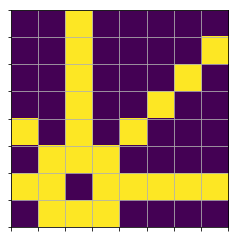

In [19]:
def plot_board(board):
    """Plots the array in checkerboard style."""
    fig, ax = plt.subplots()
    ax.imshow(board, origin='lower')
    ax.set_xticks(np.arange(-0.5, N+0.5, 1))
    ax.set_yticks(np.arange(-0.5, N+0.5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    plt.show()

N = 8  # chess board width / height
plot_board(get_queen_moves(pre_idx=10, pop_size=N**2))

## Exercise 4 - Putting Things Together
Now, let's finally start to put all things together and simulate the neurons.

1. First, complete the code below with your solutions from Exercise 2.

```Python 
start_scope()  # brian wants to now the scope
defaultclock.dt = 0.001*second  # simulation timesteps -> accuracy vs. speed trade-off
T = 5  # simulation time
noise_rate = ???*Hz  # noisy input 
noise_weight = ???  # noise connection strength
exc_weight = ??? * noise_weight  # excitatory connection strength
inh_weight = ??? * noise_weight  # inhibitory connection strength
tau = 30*ms  # time constant -> spikes decay with 1/tau

## create populations
# create a population that represents the squares on a chess board
board = ???
                    
board.v = ??? # initialize all neurons a bit differently

# create a population for noisy, uncorrelated input
noise_pop = ???

## create connections
# all neurons get a noisy input
noise_syn = Synapses(noise_pop, board, on_pre='???')
noise_syn.connect(???)

# all neurons are self-excitatory
e_syn = Synapses(board, board,  on_pre='???')
e_syn.connect(???)

# inhibitory connections represent the possible moves of the queen
inh_syn = Synapses(board, board,  on_pre='v???=inh_weight')
for pre_idx in range(N**2):
    # "place one queen at a time" to initialize connectivity
    post_array = np.where(get_queen_moves(???, ???).flatten())[0]
    inh_syn.connect(i=???, j=post_array)
```

In [26]:
start_scope()  # brian wants to now the scope
defaultclock.dt = 0.001*second  # simulation timesteps -> accuracy vs. speed trade-off
T = 5  # simulation time
N = 4
noise_rate = 300*Hz  # noisy input 
noise_weight = 0.3  # noise connection strength
exc_weight = 10 * noise_weight  # excitatory connection strength
inh_weight = -10 * noise_weight  # inhibitory connection strength
tau = 30*ms  # time constant -> spikes decay with 1/tau

## create populations
# create a population that represents the squares on a chess board
board = NeuronGroup(N**2, eqs, threshold='v>1', reset='v=0', method='exact',refractory='(1 + rand())*ms')
                    
board.v = 'rand()*v'  # initialize all neurons a bit differently

# create a population for noisy, uncorrelated input
noise_pop = PoissonGroup(N**2, rates=input_rate)

## create connections
# all neurons get a noisy input
noise_syn = Synapses(noise_pop, board, on_pre='v += noise_weight')
noise_syn.connect()

# all neurons are self-excitatory
e_syn = Synapses(board, board,  on_pre='v += exc_weight')
e_syn.connect('i==j')

# inhibitory connections represent the possible moves of the queen
inh_syn = Synapses(board, board,  on_pre='v += inh_weight')
for pre_idx in range(N**2):
    # "place one queen at a time" to initialize connectivity
    post_array = np.where(get_queen_moves(pre_idx, N**2).flatten())[0]
    inh_syn.connect(i=pre_idx, j=post_array)

2. Check wether the inhibitory synapses are correctly connected. Here's a function to visualize it (from brian2's tutorial on synapses). Run the code below. With N=4 it should create the pattern as in the image below. You can use it to visualize `exc_syn` or `noise_syn` as well.

```Python
def visualise_connectivity(S):
    """Visualize the connectivity S (for Synapses).
    Adapted from the Tutorial 2-intro-to-brian-synapses.ipynb.
    """
    %matplotlib inline
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
visualise_connectivity(inh_syn)
```

<img src="https://i.ibb.co/dm7F9XH/02-n-queens-pattern.png">

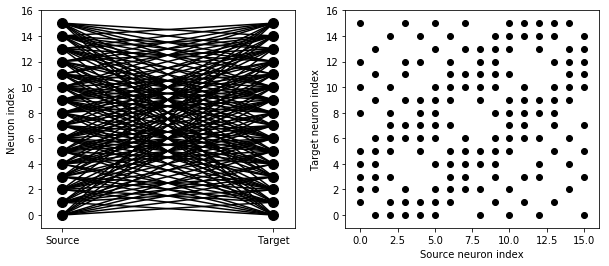

In [27]:
def visualise_connectivity(S):
    """Visualize the connectivity S (for Synapses).
    Adapted from the Tutorial 2-intro-to-brian-synapses.ipynb.
    """
    %matplotlib inline
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(inh_syn)

3. Create monitors. Brian2's `StateMonitor` and `SpikeMonitor` can generically store the variables of interest. Let's monitor the membrane potential `v` and spikes of the "board". Hint: search in the [official tutorials](https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html) for `StateMonitor` and `SpikeMonitor` to find out how to do that. Finally, run the simulation by executing the last line (make sure that the scope is correct, you might want to copy the code from 4.1 into the same cell):
```Python
spike_monitor = SpikeMonitor(???)
state_monitor = StateMonitor(???)
run(T*second)
```

In [38]:
spike_monitor = SpikeMonitor(board)
state_monitor = StateMonitor(S, ['v'], record=True)
run(T*second)

WARNING    "statemonitor_1" has been included in the network but not the object on which it depends.Setting "statemonitor_1" to inactive. [brian2.core.magic.dependency_warning]


## Exercise 5 - Visualizing the Results
Here comes the fun part. We have prepared some functions for visualization where you can simply plug the state- and spikemonitor into. 

1. Use the function `plot_potentials()` for visualizing every neurons membrane potential on an $N\times N$ grid. What do you observe? Can you explain it?
```Python
def plot_potentials(state_monitor):
    """Plots the membrane potentials"""
    %matplotlib inline
    N2, steps = state_monitor.v.shape
    N = int(np.sqrt(N2))
    v = state_monitor.v.reshape(N, N, steps)
    time = np.arange(0, T, defaultclock.dt.item())
    for row in range(N):
        for column in range(N):
            ax = plt.subplot2grid((N, N), (row, column))
            ax.plot(time, v[row, column])
            ax.axis('off')
    plt.show()
```

ValueError: x and y must have same first dimension, but have shapes (5000,) and (0,)

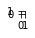

In [39]:
def plot_potentials(state_monitor):
    """Plots the membrane potentials"""
    %matplotlib inline
    N2, steps = state_monitor.v.shape
    N = int(np.sqrt(N2))
    v = state_monitor.v.reshape(N, N, steps)
    time = np.arange(0, T, defaultclock.dt.item())
    for row in range(N):
        for column in range(N):
            ax = plt.subplot2grid((N, N), (row, column))
            ax.plot(time, v[row, column])
            ax.axis('off')
    plt.show()
plot_potentials(state_monitor)

2. Use the second function, `plot_board_temporal()`, for visualizing activity temporally as a "video". What can you control with the function parameters `active_only` and `every_nth`? Can we read the solution from the video?

```Python
def get_board_temporal(spike_monitor):
    """Returns array of shape (timesteps, N, N)."""
    board_t = np.zeros([int(T/defaultclock.dt.item()), N**2])
    for neuron, spikes in spike_monitor.all_values()['t'].items():
        for spike_t in spikes:
            time_idx = int(spike_t/defaultclock.dt.item())
            board_t[time_idx, neuron] = 1
    board_t = board_t.reshape(-1, N, N)
    return board_t

def plot_board_temporal(spike_monitor, every_nth=10, active_only=True):
    """Plots the spikes successively.
    
    Args:
        every_nth (int): plot every n-th (temporally) checkerboard.
        spikes_only (bool): if True, plots only checkerboards with activity.
    """
    %matplotlib notebook
    board_t = get_board_temporal(spike_monitor)
    fig, ax = plt.subplots(figsize=[4, 4])
    #ax.axis('off')
    ax.set_xticks(np.arange(-0.5, N+0.5, 1))
    ax.set_yticks(np.arange(-0.5, N+0.5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    img = ax.imshow(board_t[0])
    img.norm.vmin=0.
    img.norm.vmax=1.
    _any = any if active_only else lambda x: True
    for i, board in enumerate(board_t[1::]):
        if _any(board) and i%every_nth==0:
            img.set_data(board)
            fig.canvas.draw()
```

<IPython.core.display.Javascript object>


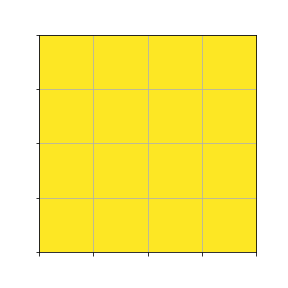

<IPython.core.display.Javascript object>


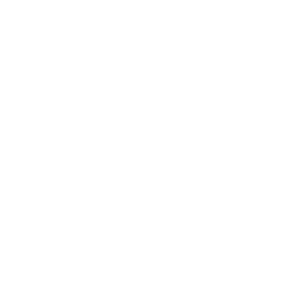

In [35]:
def get_board_temporal(spike_monitor):
    """Returns array of shape (timesteps, N, N)."""
    board_t = np.zeros([int(T/defaultclock.dt.item()), N**2])
    for neuron, spikes in spike_monitor.all_values()['t'].items():
        for spike_t in spikes:
            time_idx = int(spike_t/defaultclock.dt.item())
            board_t[time_idx, neuron] = 1
    board_t = board_t.reshape(-1, N, N)
    return board_t

def plot_board_temporal(spike_monitor, every_nth=10, active_only=True):
    """Plots the spikes successively.
    
    Args:
        every_nth (int): plot every n-th (temporally) checkerboard.
        spikes_only (bool): if True, plots only checkerboards with activity.
    """
    %matplotlib notebook
    board_t = get_board_temporal(spike_monitor)
    fig, ax = plt.subplots(figsize=[4, 4])
    #ax.axis('off')
    ax.set_xticks(np.arange(-0.5, N+0.5, 1))
    ax.set_yticks(np.arange(-0.5, N+0.5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid()
    img = ax.imshow(board_t[0])
    img.norm.vmin=0.
    img.norm.vmax=1.
    _any = any if active_only else lambda x: True
    for i, board in enumerate(board_t[1::]):
        if _any(board) and i%every_nth==0:
            img.set_data(board)
            fig.canvas.draw()
plot_board_temporal(spike_monitor)

3. Finally, we would like to see the solution to the n-Queens problem at a single glance. Run the function `plot_solution()` below. Is it a valid solution? Do we always get a valid solutions if we rerun the simulation? Are there other ways then by ranking the temporal mean activity? What assumption does this evaluation rely on?

```Python 
def plot_solution(spike_monitor, bestN=True):
    """Plots the spike frequency per neuron."""
    %matplotlib inline
    board_t = get_board_temporal(spike_monitor)
    board = board_t.mean(axis=0)
    if bestN:
        _board = board.flatten()
        _board.sort()
        _min = _board[::-1][N-1]
        board[board<_min] = 0
    plot_board(board)
```

In [34]:
def plot_solution(spike_monitor, bestN=True):
    """Plots the spike frequency per neuron."""
    %matplotlib inline
    board_t = get_board_temporal(spike_monitor)
    board = board_t.mean(axis=0)
    if bestN:
        _board = board.flatten()
        _board.sort()
        _min = _board[::-1][N-1]
        board[board<_min] = 0
    plot_board(board)

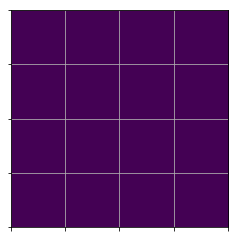

In [36]:
plot_solution(spike_monitor)